# Some notes about recent dolo development

## Toolchain

- build tool: `poetry`
    - simplifies dependency management
    - `setup.py` disappeared
    - `pyproject.toml`
    - install `poetry` then `pip install .`
- tag-based releases:
    - automatic release on pypi when tag is pushed to master
    - semi-automatic release from pypi to conda
- documentation switch to github/actions + mkdocs:
    - old: `www.econforge.org/dolo`
    - new: `www.econforge.org/dolo.py`
    - built and published on tag-release
- advertisement: try `mamba` instead of `conda` !

## Development choices


- semi-object oriented programming:
    - type hierarchy
    - mostly stateless design
        - most objects are simple datastructures with simple internal state
- multiple dispatch
- use optional typing:
    - mostly for documentation
    - almost completely useless at runtime
- performance
    - numba-ification out of reach (no @jitclass) but...
    - some objects have a typed numba equivalent

### Numbaification

In [45]:
# numba-ification
from dolo.numeric.grids import UniformCartesianGrid, NonUniformCartesianGrid
grid = UniformCartesianGrid(min=[0.0, 0.0], max=[1.0, 1.0], n=[10, 10])
display(grid)
display(grid.__numba_repr__())   # fully type inferrable by numba / interpolation.py

((0.0, 1.0, 10), (0.0, 1.0, 10))

In [47]:
import numba
numba.typeof(grid.__numba_repr__())

UniTuple(Tuple(float64, float64, int64) x 2)

In [52]:
import numpy as np
grid = NonUniformCartesianGrid([np.linspace(0,1,10), np.linspace(0,1,10)])
numba.typeof( grid.__numba_repr__() )

UniTuple(array(float64, 1d, C) x 2)

### Stateless / Statefree

In [ ]:
# problem 1

class Model:
    
    def __init__(self, a=1, b=2):
        self.a = a
        self.b = b
        
    def solve(self):
        return self.a + self.b
        
        
d = dict(a=1, b=2.5)
model = Model(**d)
model.solve() # -> 3.4

d['a'] = 1.5 # bad student
model.solve() # -> I paid for this school, why don't I get 4.0 ?

# solutions:

# - terminate student

# - promote no reference style of coding:

m = Model()
m.a = 1
m.b = 2

# - educate by providing feedback when parameter is set (see below)

In [ ]:
class Model:
    
    def __init__(self, a=1)
        self.a
    
    def update():
        self.b = self.a+1
        
    def solve():
        returb self.a+self.b

model = Model()
model.update()  # bad design
model.solve()

In [10]:
# stateless / stateful

class Model:
    
    a = 1
    
    def update():
        self.b = self.a+1
        
    def solve():
        returb self.a+self.b

model = Model()
model.update()
model.solve()

model.a = 2
# model.update()  # bad design
model.solve()

((0.0, 1.0, 10), (0.0, 1.0, 10))

two tools to improve the situation:
- user-experience:
    - properties
- developper experience:
    - decorators / annotations
    - traits

In [ ]:
class Model:
    
    @property
    def a():
        return self._a_
    
    @a.setter
    def a(self, value):
        print(f"Parameter 'a' set to {value}") # for the bad student
        self._a_ = value
        self.update()
        
    def update():
        self.b = self.a+1
        
    def solve():
        returb self.a + self.b

model = Model()
model.a = 2 # triggers update()
model.solve() # -> 3

## ok but requires lots of recalculations with many parameters

In [ ]:
# better solution with global flag

class Model:
        
    __parameters_reset__ = True
    
    @property
    def a():
        return self._a_
    
    @a.setter
    def a(self, value):
        print(f"Parameter 'a' set to {value}") # for the bad student
        self._a_ = value
        self.update()
        
    @property
    def b():
        return self._b_
    
    @a.setter
    def b(self, value):
        print(f"Parameter 'b' set to {value}") # for the bad student
        self._b_ = value
        self.update()
        
    def update():
        if __parameters_reset__:
            self.c = self.a+1
            __parameters_reset__ = False
        
    def solve():
        returb self.a + self.b

model = Model()
model.a = 2 # triggers update()
model.solve() # -> 3

In [23]:
# same code with traits: (many possible syntaxes)

# better solution with global flag

@magiclass
class Model:
        
    a: Parameter[Float]    
    b: Parameter[Float]

    @depends(['a', 'b'])
    def update():
        if __parameters_reset__:
            self.c = self.a+1
            __parameters_reset__ = False
        
    @depends(['update'])
    def solve():
        return self.a + self.b

        
model = Model()
model.a = 2.0  # resets `self.__reset__['update']` and `self.__reset__['solve']` to True
model.b = 2.0  # same
model.solve()  # will need to recompute update(), which in turn, will take new values of a and b

NameError: name 'magiclass' is not defined

In [ ]:
# other approach

class MagicalDict:
    
    dependencies: Dict[]
    def __init__(self, model):
        self.model = model
    
    def __setitem__(self, k, v):
        pass #

    
    

class Model

    calibration: MagicalDict
        
model = Model()
model.calibration['a'] = 1 # same behaviour

### Stateless approach in dolo

In [53]:
# mostly stateless

from dolo import *
model = yaml_import("examples/models/rbc_iid.yaml")
dr = time_iteration(model, details=False, verbose=False)
simulate(model, dr, N=10)

<xarray.DataArray (T: 40, N: 10, V: 9)>
array([[[ 0.00000000e+00,  0.00000000e+00,  9.35497829e+00, ...,
          7.61398778e-01,  3.50741693e-02,  2.02103089e+00],
        [ 2.16900189e-02,  0.00000000e+00,  9.35497829e+00, ...,
          7.61398778e-01,  3.50741693e-02,  2.02103089e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.35497829e+00, ...,
          7.61398778e-01,  3.50741693e-02,  2.02103089e+00],
        ...,
        [ 2.16900189e-02,  0.00000000e+00,  9.35497829e+00, ...,
          7.61398778e-01,  3.50741693e-02,  2.02103089e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.35497829e+00, ...,
          7.61398778e-01,  3.50741693e-02,  2.02103089e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.35497829e+00, ...,
          7.61398778e-01,  3.50741693e-02,  2.02103089e+00]],

       [[-2.16900189e-02,  0.00000000e+00,  9.35400230e+00, ...,
          7.61384391e-01,  3.50776803e-02,  2.02093125e+00],
        [ 2.16900189e-02,  2.16900189e-02,  9.35400230e+00, ...,
          7.62822957e-01,  3.60682624e-02,  2.05898938e+00],
        [ 2.16900189e-02,  0.00000000e+00,  9.35400230e+00, ...,
          7.61384391e-01,  3.50776803e-02,  2.02093125e+00],
        ...,
        [ 0.00000000e+00,  2.16900189e-02,  9.35400230e+00, ...,
          7.62822957e-01,  3.60682624e-02,  2.05898938e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.35400230e+00, ...,
          7.61384391e-01,  3.50776803e-02,  2.02093125e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.35400230e+00, ...,
          7.61384391e-01,  3.50776803e-02,  2.02093125e+00]],

       [[ 0.00000000e+00, -2.16900189e-02,  9.35306089e+00, ...,
          7.59958581e-01,  3.41148441e-02,  1.98356112e+00],
        [-2.16900189e-02,  3.90420340e-02,  9.37970083e+00, ...,
          7.64374529e-01,  3.67820030e-02,  2.09271518e+00],
        [ 0.00000000e+00,  2.16900189e-02,  9.35306089e+00, ...,
          7.62809192e-01,  3.60717286e-02,  2.05889192e+00],
        ...,
        [ 0.00000000e+00,  1.73520151e-02,  9.37970083e+00, ...,
          7.62909791e-01,  3.57742049e-02,  2.05396620e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.35306089e+00, ...,
          7.61370512e-01,  3.50810677e-02,  2.02083514e+00],
        [-2.16900189e-02,  0.00000000e+00,  9.35306089e+00, ...,
          7.61370512e-01,  3.50810677e-02,  2.02083514e+00]],

       ...,

       [[-2.16900189e-02, -1.07439022e-03,  9.61420916e+00, ...,
          7.65100181e-01,  3.41202851e-02,  2.04538252e+00],
        [-2.16900189e-02,  1.40518882e-02,  9.34551078e+00, ...,
          7.62189721e-01,  3.57475889e-02,  2.04462352e+00],
        [-2.16900189e-02, -2.45856318e-02,  9.27466543e+00, ...,
          7.58599962e-01,  3.42649707e-02,  1.97074028e+00],
        ...,
        [-2.16900189e-02, -3.32566969e-03,  9.07518640e+00, ...,
          7.56987961e-01,  3.59598257e-02,  1.98647444e+00],
        [ 2.16900189e-02, -4.46909134e-03,  9.14991498e+00, ...,
          7.58044345e-01,  3.56244995e-02,  1.99225926e+00],
        [ 0.00000000e+00, -3.56943011e-02,  9.04737363e+00, ...,
          7.54422827e-01,  3.45998302e-02,  1.92907212e+00]],

       [[-2.16900189e-02, -2.25495311e-02,  9.60281302e+00, ...,
          7.63568665e-01,  3.32232268e-02,  2.00702789e+00],
        [ 0.00000000e+00, -1.04485083e-02,  9.36204534e+00, ...,
          7.60820733e-01,  3.45806083e-02,  2.00369527e+00],
        [ 0.00000000e+00, -4.13585243e-02,  9.24721744e+00, ...,
          7.57116396e-01,  3.36272937e-02,  1.93988298e+00],
        ...,
        [-2.16900189e-02, -2.43505546e-02,  9.08023430e+00, ...,
          7.55667124e-01,  3.49847249e-02,  1.95134965e+00],
        [ 0.00000000e+00,  1.81147458e-02,  9.15088379e+00, ...,
          7.59578184e-01,  3.66655795e-02,  2.03152971e+00],
        [ 2.16900189e-02, -2.85554409e-02,  9.01536523e+00, ...,
          7.54392233e-01,  3.50390162e-02,  1.93766096e+00]],

       [[ 4.57115202e-02, -3.97296437e-02,  9.56595110e+00, ...,
          7.61963572e-01,  

In [ ]:
# with some exceptions
model.set_calibration(beta=0.96)  # (sets global flag)

In [63]:
sol = time_iteration(model, details=True, verbose=False)
sol

TimeIterationResult(dr=<dolo.numeric.decision_rule.DecisionRule object at 0x7fb649ecfc90>, iterations=126, complementarities=True, dprocess=FiniteDistribution(points=array([[-0.04571152],
       [-0.02169002],
       [ 0.        ],
       [ 0.02169002],
       [ 0.04571152]]), weights=array([0.01125741, 0.22207592, 0.53333333, 0.22207592, 0.01125741]), origin=Normal(Μ=[0.],Σ=[[0.000256]])), x_converged=True, x_tol=1e-06, err=9.689385253586202e-07, log=None, trace=None)

In [62]:
model.discretize()[1]

AttributeError: 'FiniteDistribution' object has no attribute 'model'

In [57]:
sol.dprocess

FiniteDistribution(points=array([[-0.04571152],
       [-0.02169002],
       [ 0.        ],
       [ 0.02169002],
       [ 0.04571152]]), weights=array([0.01125741, 0.22207592, 0.53333333, 0.22207592, 0.01125741]), origin=Normal(Μ=[0.],Σ=[[0.000256]]))

## Towards more separatation between pure objects and discretized ones

In [36]:
model.domain

{'z': array([-0.05333333,  0.05333333]),
 'k': array([ 4.67748915, 14.03246744])}

In [59]:
grid, dprocess = model.discretize()
display( grid )
display( dprocess  )
# model.grid will disappear but there might be a DiscretizedModel object with a pointer to its parent.

<dolo.numeric.grids.EmptyGrid object at 0x7fb64b5c4210> × <dolo.numeric.grids.UniformCartesianGrid object at 0x7fb64b5c48d0>

FiniteDistribution(points=array([[-0.04571152],
       [-0.02169002],
       [ 0.        ],
       [ 0.02169002],
       [ 0.04571152]]), weights=array([0.01125741, 0.22207592, 0.53333333, 0.22207592, 0.01125741]), origin=Normal(Μ=[0.],Σ=[[0.000256]]))

# Processes and Distributions



Three separate concepts:
    
- distribution ($\epsilon$):

    - does `dist.draw(N: int)`, `dist.integrate(f)`

- processes $(\epsilon_t)_{t}$:

    - does `dist.simulate()`

- discretized process:

    - does `dist.node(i)`, `dist.inode(i,j)`, `dist.iweight(i,j)`
    - used to solve models

With multiple inheritances, it is possible to belong to several classes: 

- a distribution is a process
- a markov chain is both a discretized process and a process

## What matters most to me:

- establish stable user-facing conventions in yaml file (***)
    - processes names must match distributions
    - documented here: http://www.econforge.org/dolo.py/processes/
    - solution:  align with distiributions.jl/R/rvlib for conventions
    - a wrapper is almost certainly needed
- define clean language API allowing for more flexibility (**) (truncations, conditional, etc.)
- simplify development process (*)
    - transaprent API
    - synchronize Python API, with Dolang API
    - less code duplication within projects (language_element decoretor @language)
    

## Distributions

- all distributions are multi-dimensional
    - 1d distribution is a special class
        - with `pdf`, `cdf` function
        - automatic equiprobable discretization
    - they carry variable names

In [64]:
from dolo.numeric.distribution import *

In [67]:
dist = UNormal(μ=0, σ=0.1)

In [72]:
from matplotlib import pyplot as plt

In [78]:
f = lambda x: x**2
scip = dist.integrate(f)

In [86]:
discr = [dist.discretize(N=n).integrate(f) for n in range(1,10)]
discr_gh = [dist.discretize(N=n, method="gauss-hermite").integrate(f) for n in range(1,10)]

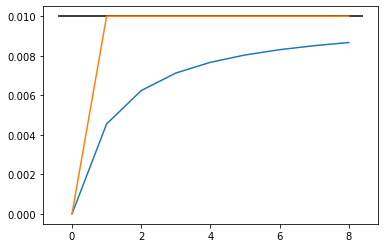

In [87]:
plt.plot(discr)
plt.plot(discr_gh)
plt.hlines(scip,*plt.xlim())

In [90]:
import numpy as np

In [92]:
trunc = Truncation[UNormal](dist=dist, lb=0, ub=np.Inf)

In [95]:
dtrunc = trunc.discretize()

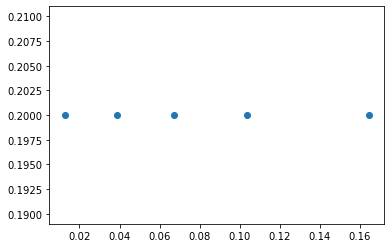

In [98]:
plt.plot(dtrunc.points.ravel(), dtrunc.weights, 'o')

In [105]:
p = ProductDistribution([dist, trunc])

In [106]:
pp = p.discretize()

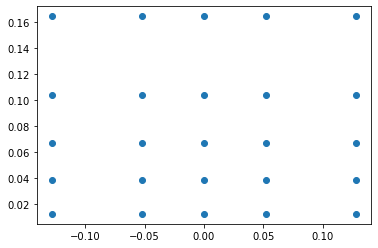

In [107]:
plt.plot(pp.points[:,0], pp.points[:,1],'o')

In [112]:
index = Bernouilli(π=0.2)

In [115]:
mix = Mixture(index=index, distributions={0: dist, 1: trunc})

In [118]:
mix.discretize().integrate(f)

array([0.00789516])

In [122]:
UNormal.simulate?

Signature:
UNormal.simulate(
    self,
    N: int = 10,
    T: int = 100,
    i0=None,
    m0=None,
    stochastic=True,
) -> xarray.core.dataarray.DataArray
Docstring: <no docstring>
File:      ~/Mobilhome/econforge/dolo/dolo/numeric/processes.py
Type:      function


In [1]:
from dolo import *

In [2]:
model = yaml_import("examples/models/rbc.yaml")

In [126]:
model.exogenous